## Table of Contents

- [1. Data Extraction](#etl)
- [2. Data Analysis](#da)
    - [2.1 Trending and Seasonality](#2_1)
    - [2.2 Outliers and Rolling Mean](#2_2)
    - [2.3 Date Columns](#2_3)
- [3. Model Training](#train)
    - [3.1 Lag](#3_1)
    - [3.2 Rolling Mean](#3_2)
    - [3.3 LightGBM](#3_3)
    - [3.4 XGBoost](#3_4)
    - [3.5 CatBoost](#3_5)
- [4. Test Predictions](#4)
- [Conclusion](#end)

### 1. Data Extraction <a class="anchor" id="etl"></a>

In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from IPython.display import display

C:\Users\matib\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
try:
    df = pd.read_csv('../datasets/taxi.csv',parse_dates=[0],index_col=[0])
    df.sort_index(inplace=True)
    display(df.head(7))
except:
    print("Data not found")

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
print("Nulls per column:")
print(df.isna().sum())

Nulls per column:
num_orders    0
dtype: int64


There is no nulls- ready to explore data trends and create features.

### 2. Data Analysis <a class="anchor" id="da"></a>

In [5]:
# resample data to 1 hour as required
dfr = df.resample('1H').sum()
display(dfr.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


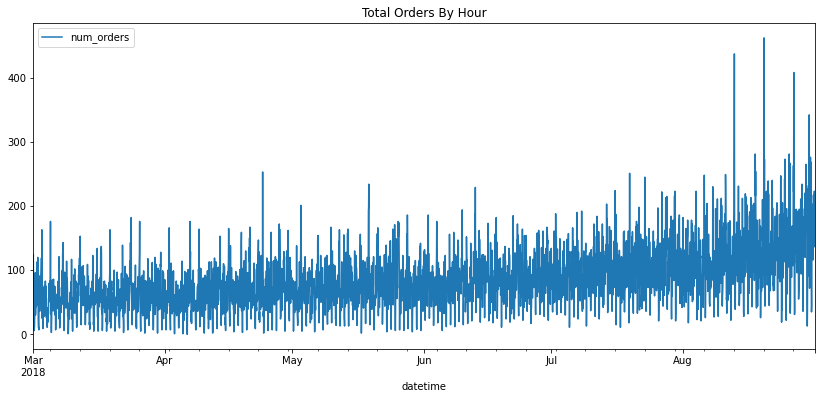

In [6]:
dfr.plot(title='Total Orders By Hour',figsize=(14,6));

#### 2.1 Trending and Seasonality <a class="anchor" id="2_1"></a>

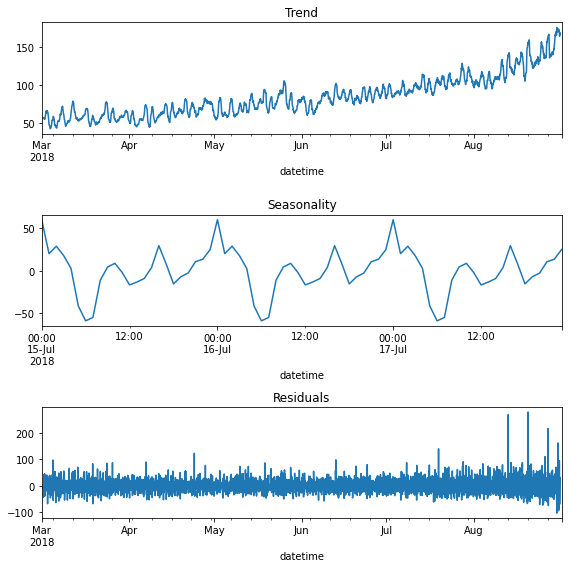

In [7]:
decomposed = seasonal_decompose(dfr)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-07-15':'2018-07-17'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

We can see a clear upward trend in the number of orders while the seasonality of the orders show the typical time of day orders or made.

#### 2.2 Outliers and Rolling Mean <a class="anchor" id="2_2"></a>

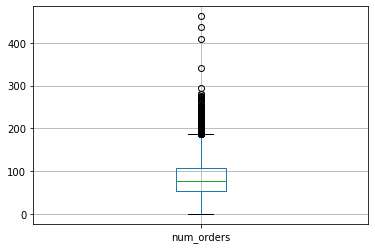

In [8]:
dfr.boxplot();

From the graph of the orders and the boxplot there are a few outliers. I will remove them for the sake of model accuracy. I will also add a default rolling mean to be adjusted later changed later.

,num_orders
count,4412.000000
mean,84.125567
std,43.927411
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,295.000000


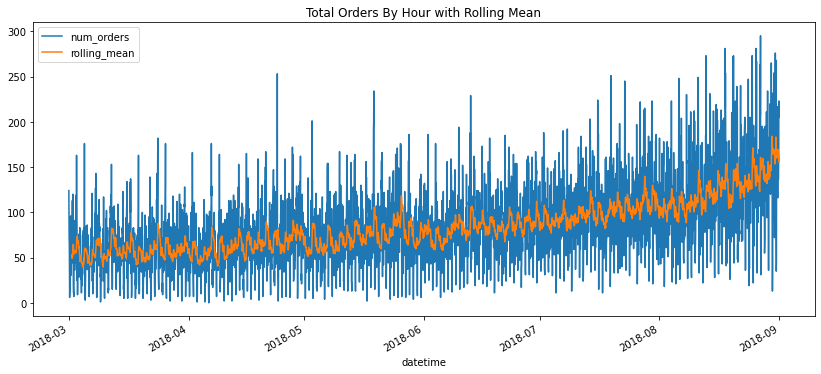

In [9]:
warnings.filterwarnings("ignore")
dfr = dfr.loc[(dfr["num_orders"] < 300)]
display(dfr.describe())

dfr['rolling_mean'] = dfr.rolling(20).mean()
dfr.plot(title='Total Orders By Hour with Rolling Mean',figsize=(14,6));

The rolling mean as expected looks similar to the trend graph. The outliers have been dealt with and now we will add some further date columns. 

#### 2.3 Date Columns <a class="anchor" id="2_3"></a>

In [10]:
# year ignored because all data from same year
dfr['month'] = dfr.index.month
dfr['day'] = dfr.index.day
dfr['dayofweek'] = dfr.index.dayofweek
dfr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4412 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4412 non-null   int64  
 1   rolling_mean  4393 non-null   float64
 2   month         4412 non-null   int64  
 3   day           4412 non-null   int64  
 4   dayofweek     4412 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 206.8 KB


During the training section we will adjust rolling mean and lag.

### 3. Model Training <a class="anchor" id="train"></a>

In [11]:
def get_rmse(y_true, y_pred):
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_value

#### 3.1 Lag <a class="anchor" id="3_1"></a>

We will test various lag sizes to see how it will effect model accuracy on simple linear regression because it is quick to train.

In [12]:
target = 'num_orders'
lag_stats = []

for max_lag in range(1,25,1):
    
    dfrl = dfr.copy()
    
    for lag in range(1, max_lag + 1):
        dfrl['lag_{}'.format(lag)] = dfrl[target].shift(lag)
        dfrl = dfrl.dropna()
        
    X = dfrl.drop([target], axis=1)
    y = dfrl[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=False)
    lr = LinearRegression().fit(X_train,y_train)
        
    tscv = TimeSeriesSplit()
    cv = cross_val_score(lr, X, y, cv=tscv)
    cv_score = np.mean(cv)*100
    
    y_pred = lr.predict(X_test)
    rmse_score = get_rmse(y_test,y_pred)
    
    lag_stats.append([max_lag,cv_score,rmse_score])

df_lag = pd.DataFrame(lag_stats,columns=['max_lag','cv_score','rmse_score'])
df_lag = df_lag.set_index('max_lag')

del dfrl

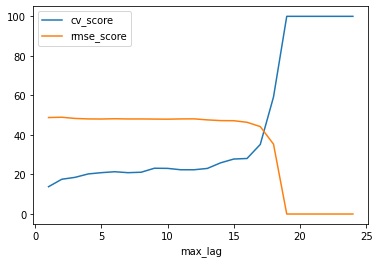

In [13]:
df_lag.plot();

We can see that after about 13 maximum lag the cv score and rmse start to converge and aren't reliable due to increase in dropped data.

In [14]:
for lag in range(1, 13 + 1):
    dfr['lag_{}'.format(lag)] = dfr[target].shift(lag)
dfr = dfr.dropna()

#### 3.2 Rolling Mean <a class="anchor" id="3_2"></a>

We will test various rolling mean sizes similarly to lag size.

In [15]:
dfrr = dfr.copy()
roll_stats = []

for rolling_mean_size in range(1,50,1):
    dfrr['rolling_mean'] = dfrr[target].shift().rolling(rolling_mean_size).mean()
    dfrr = dfrr.dropna()
    X = dfrr.drop([target], axis=1)
    y = dfrr[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=False)
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    tscv = TimeSeriesSplit()
    cv = cross_val_score(lr, X, y, cv=tscv)
    cv_score = np.mean(cv)*100
    
    y_pred = lr.predict(X_test)
    rmse = get_rmse(y_test, y_pred)
    
    roll_stats.append([rolling_mean_size,cv_score,rmse])
    
df_roll = pd.DataFrame(roll_stats,columns=['rolling_mean_size','cv_score','test_rmse'])
df_roll = df_roll.set_index('rolling_mean_size')

del dfrr

,cv_score,test_rmse
rolling_mean_size,,
25,22.272438,47.813913
26,22.239899,47.771968
27,22.143553,48.091997
24,22.069039,47.994708
28,21.922221,48.697685
29,21.571728,48.868643
9,21.564190,49.592401
10,21.518887,49.631313
30,21.300902,49.265936


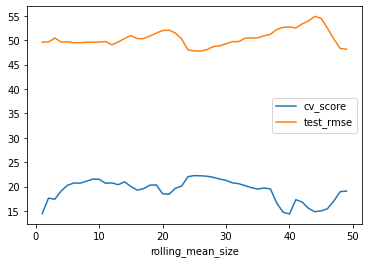

In [16]:
display(df_roll.sort_values(by='cv_score',ascending=False).head(10))
df_roll.plot();

The rolling mean at 25 gives the lowest RMSE and best cross validation score so we will use a rolling mean size of 25.

In [17]:
dfr['rolling_mean'] = dfr[target].shift().rolling(25).mean()

We will train various models with our data:

In [18]:
X = dfr.drop([target], axis=1)
y = dfr[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=False)

#### 3.3 LightGBM <a class="anchor" id="3_3"></a>

In [19]:
%%time
gbm = lgb.LGBMRegressor()
start = time.time()
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')
end = time.time()
lgbm_time = end - start

[1]	valid_0's rmse: 76.7169	valid_0's l2: 5885.48
[2]	valid_0's rmse: 73.4888	valid_0's l2: 5400.61
[3]	valid_0's rmse: 70.8832	valid_0's l2: 5024.43
[4]	valid_0's rmse: 68.5193	valid_0's l2: 4694.89
[5]	valid_0's rmse: 66.5407	valid_0's l2: 4427.66
[6]	valid_0's rmse: 64.3013	valid_0's l2: 4134.66
[7]	valid_0's rmse: 62.655	valid_0's l2: 3925.65
[8]	valid_0's rmse: 61.5546	valid_0's l2: 3788.97
[9]	valid_0's rmse: 60.0992	valid_0's l2: 3611.91
[10]	valid_0's rmse: 59.0978	valid_0's l2: 3492.54
[11]	valid_0's rmse: 58.3922	valid_0's l2: 3409.64
[12]	valid_0's rmse: 57.3907	valid_0's l2: 3293.69
[13]	valid_0's rmse: 56.8665	valid_0's l2: 3233.79
[14]	valid_0's rmse: 55.9074	valid_0's l2: 3125.63
[15]	valid_0's rmse: 55.2905	valid_0's l2: 3057.03
[16]	valid_0's rmse: 54.7255	valid_0's l2: 2994.88
[17]	valid_0's rmse: 54.0696	valid_0's l2: 2923.53
[18]	valid_0's rmse: 53.5191	valid_0's l2: 2864.29
[19]	valid_0's rmse: 53.1345	valid_0's l2: 2823.27
[20]	valid_0's rmse: 52.8978	valid_0's l2

In [20]:
%%time
start = time.time()
predictions = gbm.predict(X_test)
end = time.time()
rmse_score = get_rmse(y_test,predictions)
tscv = TimeSeriesSplit()
cv = cross_val_score(gbm, X, y, cv=tscv)
final_score = pd.Series(cv).mean()*100

print(f'RMSE: {rmse_score:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score))

RMSE: 46.36
Average model evaluation score: 24.98%
Wall time: 321 ms


#### 3.4 XGBoost <a class="anchor" id="3_4"></a>

In [21]:
%%time
xg = xgb.XGBRegressor()
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
xg_time = end - start

Wall time: 294 ms


In [22]:
%%time
start = time.time()
predictions = xg.predict(X_test)
end = time.time()
rmse_score = get_rmse(y_test,predictions)
tscv = TimeSeriesSplit()
cv = cross_val_score(xg, X, y, cv=tscv)
final_score = pd.Series(cv).mean()*100

print(f'RMSE: {rmse_score:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score))

RMSE: 50.55
Average model evaluation score: 18.91%
Wall time: 930 ms


#### 3.5 CatBoost <a class="anchor" id="3_5"></a>

In [23]:
%%time
# no categorical columns
cb = CatBoostRegressor(loss_function="RMSE",verbose=500)
start = time.time()
cb.fit(X_train, y_train, eval_set=(X_test, y_test))
end = time.time()
catboost_time = end - start

Learning rate set to 0.063185
0:	learn: 37.4501803	test: 79.0947411	best: 79.0947411 (0)	total: 159ms	remaining: 2m 38s
500:	learn: 17.0359075	test: 45.5550297	best: 45.5471865 (497)	total: 984ms	remaining: 980ms
999:	learn: 12.3407488	test: 44.4637637	best: 44.4382499 (909)	total: 1.8s	remaining: 0us

bestTest = 44.43824986
bestIteration = 909

Shrink model to first 910 iterations.
Wall time: 1.99 s


In [24]:
%%time
start = time.time()
predictions = cb.predict(X_test)
end = time.time()
rmse = get_rmse(y_test,predictions)
tscv = TimeSeriesSplit()
cv = cross_val_score(cb, X, y, cv=tscv)
final_score = pd.Series(cv).mean()
print(f'RMSE: {rmse:.2f}')
print("Average model evaluation score: {:.2f}%".format(final_score*100))

Learning rate set to 0.038982
0:	learn: 29.2795966	total: 33.5ms	remaining: 33.5s
500:	learn: 9.4541139	total: 519ms	remaining: 517ms
999:	learn: 4.5812172	total: 959ms	remaining: 0us
Learning rate set to 0.043489
0:	learn: 30.5076414	total: 10.4ms	remaining: 10.4s
500:	learn: 12.1073530	total: 568ms	remaining: 565ms
999:	learn: 7.1925751	total: 1.12s	remaining: 0us
Learning rate set to 0.046365
0:	learn: 32.4911067	total: 2.97ms	remaining: 2.97s
500:	learn: 13.6356309	total: 642ms	remaining: 640ms
999:	learn: 9.2928095	total: 1.31s	remaining: 0us
Learning rate set to 0.04852
0:	learn: 33.3264323	total: 2.88ms	remaining: 2.87s
500:	learn: 15.8444601	total: 823ms	remaining: 820ms
999:	learn: 11.3810733	total: 1.52s	remaining: 0us
Learning rate set to 0.050261
0:	learn: 36.0930296	total: 13.7ms	remaining: 13.7s
500:	learn: 17.5383305	total: 837ms	remaining: 834ms
999:	learn: 13.0529652	total: 1.65s	remaining: 0us
RMSE: 44.44
Average model evaluation score: 30.37%
Wall time: 7.11 s


The CatBoost model performed best. We will now examine its predictions.

### 4. Test Predictions <a class="anchor" id="4"></a>

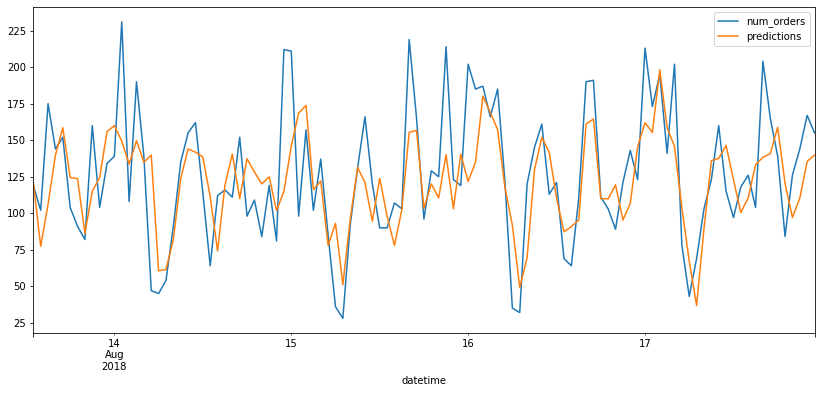

In [25]:
y_actual = y_test.copy()
y_predict = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_test = pd.merge(y_actual, y_predict, how = 'left', left_index = True, right_index = True)
df_test['predictions'] = df_test['predictions']
df_test['2018-07-15':'2018-08-17'].plot(figsize=(14,6));

On closer examination of the model predictions they look quite accurate- predictions line up closely with actual order numbers.

## Conclusion <a class="anchor" id="end"></a>

We managed to achieve a RMSE lower than 48 in our predictive model. The upward trend was clear in the data. Once again CatBoost emerged as the best method. The data preperations and additional features aided in creating a visibly accurate model.